In [ ]:
!nvidia-smi

Tue Mar 23 16:51:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Libraries

In [ ]:

#importing libraries
from tensorflow.keras import datasets, utils, models, applications
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, LeakyReLU, Reshape
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception, preprocess_input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
batch_size = 128
num_classes = 10
epochs = 20


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
(X_train, Y_train), (X_test, Y_test) = load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

## Defining Generator function 

In [ ]:
def discriminator_model(input_shape = (28,28,1)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),strides = (2,2),input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(64,kernel_size = (3, 3),strides=(2,2)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(1,activation='sigmoid'))

    return model


def generator_model(input_dim = 100):
    ip_neurons = 256
    model = Sequential()
    model.add(Dense(7*7*ip_neurons,use_bias = False, input_dim = input_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, ip_neurons)))
    model.add(layers.Conv2DTranspose(ip_neurons//2, (5, 5), strides=(1, 1), padding='same'))
    #at this point dimensions are 7 * 7 * 128 
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(layers.Conv2DTranspose(ip_neurons//4, (5, 5), strides=(2, 2), padding='same'))
    #dim becomes 14 * 14 * 64
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    #dimensions becomes equivalent to mnist image that is 28 * 28 * 1

    return model



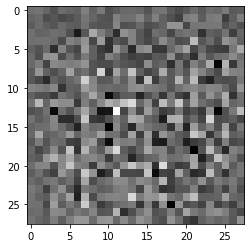

In [ ]:
%%time
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
discriminator = discriminator_model()
output = discriminator(generated_image)
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5008129]], dtype=float32)>

In [ ]:
#make GAN using sequential gen, desc
gan = keras.models.Sequential([generator, discriminator])
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

gan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         2331137   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 249417    
Total params: 2,580,554
Trainable params: 2,305,665
Non-trainable params: 274,889
_________________________________________________________________


In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))           
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        # plot_multiple_images(generated_images, 8)                     # not shown
        # plt.show()    
X_train = X_train/255
X_test = X_test/255

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan,dataset,batch_size,100,1)

Epoch 1/1


InvalidArgumentError: ignored

In [ ]:
y_train = utils.to_categorical(Y_train)
y_test = utils.to_categorical(Y_test)

training_batch_generator = GeneratorFunction(X_train, y_train, 299, 299, batch_size, 'Training Generator')
validation_batch_generator = GeneratorFunction(X_test, y_test, 299, 299, batch_size, 'Validation Generator')


model =Sequential()
model.add(GlobalAveragePooling2D(input_shape=pretrained_model.output_shape[1:]))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(training_batch_generator, steps_per_epoch = X_train.shape[0]//batch_size, epochs = 2, verbose = 1, validation_data=validation_batch_generator)

Epoch 1/2
390/390 [==============================] - ETA: 0s - loss: 0.8132 - accuracy: 0.7791

In [ ]:
#prediction using test set
score = model.evaluate(X_test, Y_test, verbose=0)
print(f'accuracy score for the Cifar10 classification of the dataset is : {score[1]}')

In [ ]:
#@title Redundant Code { display-mode: "form" }
%%time
training_history = None
try:
   training_history =  model.fit(
    X_train,
        Y_train,
        validation_data = (X_test,Y_test),
        batch_size = batch_size,
        epochs = epochs,
        shuffle = True,
        verbose = 1
    )
except KeyboardInterrupt as e:
    print("\njust wait to complete training!!\n")

In [ ]:
#@title Alternate Model  { display-mode: "form" }
import cv2
from numpy import array, argmax
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, utils, models, optimizers
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_train = array([cv2.resize(i, dsize=(72, 72), interpolation=cv2.INTER_CUBIC) for i in x_train])
x_train = preprocess_input(x_train)
x_test = array([cv2.resize(i, dsize=(72, 72), interpolation=cv2.INTER_CUBIC) for i in x_test])
x_test = preprocess_input(x_test)

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
model_xception = Xception(include_top=False, weights='imagenet', input_shape=(72, 72, 3), pooling=None)

del y_train,y_test
#model_xception.summary()

x_train = model_xception.predict(x_train)
x_test = model_xception.predict(x_test)
model = models.Sequential()
model.add(GloalAveragePooling2D(input_size=(7, 7, 2048)))
model.add(Dropout(0.3))
model.add(Dense(x_test.shape[1], activaton='softmax'))

# model.summary()
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=10, verbose = True)
prediction = model.predict(x_test)

print(prediction)

y_test = argmax(y_test, axis=1)
prediction = argmax(prediction, axis=1)

print('\nAccuracy:', metrics.accuracy_score(y_test, prediction, normalize=True))
print('\nClassification Report:' + metrics.classification_report(y_test, prediction) + '\nConfusion Matrix:')
print(metrics.confusion_matrix(y_test, prediction))

In [ ]:
#@title Redundant Code
img_rows, img_cols = 32, 32
y_train,y_test = Y_train,Y_test
input_shape = (img_rows, img_cols, 3)
# convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

In [ ]:
#@title Redundant code { display-mode: "form" }
lst = []
i =1
while 1:
    i +=1
    lst.append('Hello'*i)